## 使用estimator，iris_training.csv，iris_test.csv，tf.data.Dataset训练

In [ ]:
import tensorflow as tf

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
CSV_TYPES = [[0.0], [0.0], [0.0], [0.0], [0]]
TRAIN_PATH = './data/iris_training.csv'
TEST_PATH = './data/iris_test.csv'

## 构建 csv 行解析器
最终，我们需要解析数据集中的每一行，以生成必要的 (features, label) 对。

我们先构建一个函数来解析单行。

以下 parse_line 函数使用 tf.decode_csv 函数和一些简单的 Python 代码完成此任务：

为了生成必要的 (features, label) 对，我们必须解析数据集中的每一行。
* 以下 _parse_line 函数会调用 tf.decode_csv，以将单行解析为特征和标签两个部分。
* 由于 Estimator 需要将特征表示为字典，因此我们依靠 Python 的内置 dict 和 zip 函数来构建此字典。
* 特征名称是该字典的键。然后，我们调用字典的 pop 方法以从特征字典中移除标签字段

In [ ]:
def _parse_line(line):
    # Decode the line into its fields
    fields = tf.decode_csv(line, record_defaults=CSV_TYPES)

    # Pack the result into a dictionary
    features = dict(zip(CSV_COLUMN_NAMES, fields))

    # Separate the label from the features
    label = features.pop('Species')

    return features, label

## 解析行
数据集提供很多用于在通过管道将数据传送到模型的过程中处理数据的方法。最常用的方法是 map，它会对 Dataset 的每个元素应用转换。

map 方法会接受 map_func 参数，此参数描述了应该如何转换 Dataset 中的每个条目。
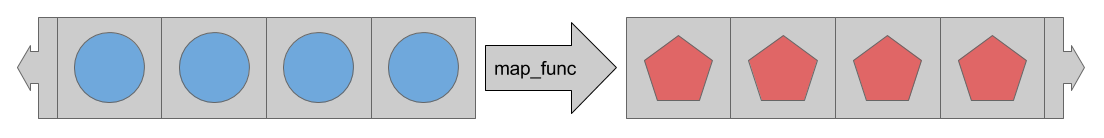

map 方法运用“map_func”来转换 Dataset 中的每个条目。 因此，为了在从 csv 文件中流式传出行时对行进行解析，我们将 _parse_line 函数传递给 map 方法：

## 参数
此函数需要三个参数。要求所赋值为“数组”的参数能够接受可通过 numpy.array 转换成数组的几乎任何值。其中存在一个例外，即对 Datasets 有特殊意义的 tuple。

* features：包含原始输入特征的 {'feature_name':array} 字典（或 DataFrame）。
* labels：包含每个样本的标签的数组。
* batch_size：表示所需批次大小的整数。

In [ ]:
def csv_input_fn(csv_path, batch_size):
    def _fn():
        # Create a dataset containing the text lines.
        dataset = tf.data.TextLineDataset(csv_path).skip(1)

        # Parse each line.
        dataset = dataset.map(_parse_line)

        # Shuffle, repeat, and batch the examples.
        dataset = dataset.shuffle(1000).repeat().batch(batch_size)

        # Return the dataset.
        return dataset
    return _fn

In [ ]:
feature_columns = [
    tf.feature_column.numeric_column(name)
    for name in CSV_COLUMN_NAMES[:-1]
]

classifier = tf.estimator.LinearClassifier(feature_columns, n_classes=3, model_dir='./tmp/iris_model')

In [ ]:
classifier.train(input_fn=csv_input_fn(TRAIN_PATH, 1024), steps=1000)
print('train finish!')

In [ ]:
accuracy_score = classifier.evaluate(input_fn=csv_input_fn(TEST_PATH, 1024), steps=1000)['accuracy']
print('\nAccuracy: {0:f}'.format(accuracy_score))